In [ ]:
# Importing the zipfile to extract the data
import zipfile

#Unzip the data
zep_ref = zipfile.ZipFile("/content/drive/MyDrive/Data Set/processed_data.zip")
zep_ref.extractall()
zep_ref.close()

In [ ]:
# Inspect the data
import os

# Walk through the directory
for dirpath, dirnames, filenames in os.walk("processed_data"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'processed_data'.
There are 2 directories and 0 images in 'processed_data/train'.
There are 0 directories and 538 images in 'processed_data/train/chilli'.
There are 0 directories and 490 images in 'processed_data/train/Unknown'.
There are 2 directories and 0 images in 'processed_data/test'.
There are 0 directories and 181 images in 'processed_data/test/chilli'.
There are 0 directories and 164 images in 'processed_data/test/Unknown'.
There are 2 directories and 0 images in 'processed_data/val'.
There are 0 directories and 179 images in 'processed_data/val/chilli'.
There are 0 directories and 163 images in 'processed_data/val/Unknown'.


In [ ]:
# Get the class_names programmatically
import numpy as np
import pathlib

data_dir = pathlib.Path("processed_data/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories
print(class_names)

['Unknown' 'chilli']


In [ ]:
# Define directory dataset paths
train_dir = "processed_data/train"
test_dir = "processed_data/val"

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 1

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode = 'categorical',
                                                               image_size = IMG_SIZE,
                                                               batch_size = BATCH_SIZE,
                                                               shuffle = True)

Found 1028 files belonging to 2 classes.
Found 342 files belonging to 2 classes.


In [ ]:
# Creating data augmentation layers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotation, zoom etc
data_augmentation = keras.Sequential([
      preprocessing.RandomFlip("horizontal"),
      preprocessing.RandomRotation(0.2),
      preprocessing.RandomZoom(0.2),
      preprocessing.RandomHeight(0.2),
      preprocessing.RandomWidth(0.2),
      #preprocessing.Rescale(1/255.)
])

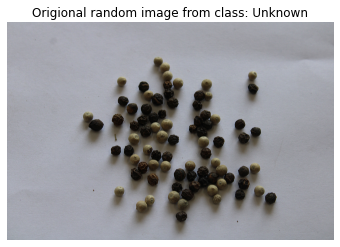

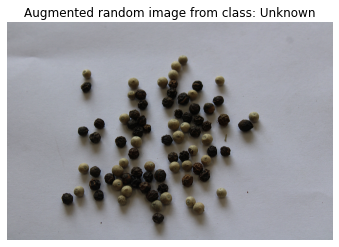

In [ ]:
# View a random image and comapre it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data.class_names)
target_dir = "processed_data/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Origional random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img,axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [ ]:
# Setup the shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in the data augmentation on Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)


# Put the dense layer on as the output
outputs = layers.Dense(2, activation='softmax', name="output_layers")(x)

# Make a model using the inputs and outputs
model = keras.Model(inputs, outputs)

In [ ]:
# Get a summary of model we've created
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layers (Dense)        (None, 2)                 2562      
Total params: 4,052,133
Trainable params: 2,562
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Creating a Early Stoppage Callback
early_stoppage = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

In [ ]:
# Fit the model
history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps= len(test_data))

Epoch 1/5
1028/1028 [==============================] - 111s 107ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 2/5
1028/1028 [==============================] - 94s 92ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 2.0314e-04 - val_accuracy: 1.0000
Epoch 3/5
1028/1028 [==============================] - 93s 90ms/step - loss: 3.4370e-04 - accuracy: 1.0000 - val_loss: 1.8337e-04 - val_accuracy: 1.0000
Epoch 4/5
1028/1028 [==============================] - 93s 90ms/step - loss: 3.6014e-04 - accuracy: 1.0000 - val_loss: 1.9763e-04 - val_accuracy: 1.0000
Epoch 5/5
1028/1028 [==============================] - 91s 88ms/step - loss: 9.5705e-05 - accuracy: 1.0000 - val_loss: 1.2404e-04 - val_accuracy: 1.0000


In [ ]:
test_loss,test_acc = model.evaluate(test_data,verbose=1)
print("\n\ntest accuarcy: ",test_acc)

342/342 [==============================] - 22s 62ms/step - loss: 1.2404e-04 - accuracy: 1.0000


test accuarcy:  1.0


In [ ]:
# Let's create a function to plot our loss curves...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss", c='r', marker='o', linestyle='dashed')
  plt.plot(epochs, val_loss, label='val_loss',  c='b', marker='*', linestyle='dashed')
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy",c='g', marker='o', linestyle='dashed')
  plt.plot(epochs, val_accuracy, label='val_accuracy', c='r', marker='*', linestyle='dashed')
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

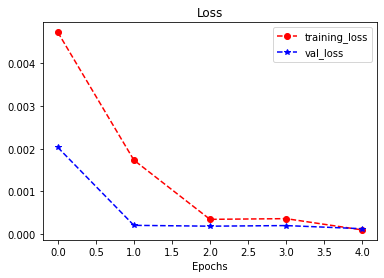

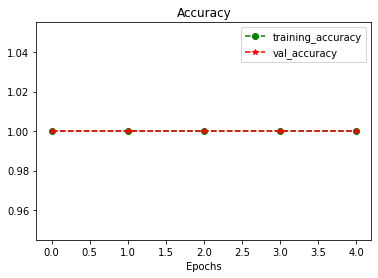

In [ ]:
# Check out our model's training curves
plot_loss_curves(history)

### **Prepare a model whole model layers for fine tuning**

In [ ]:
# Are any of the layers in our model frozen?
for layer in model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
sequential True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "float32">
global_average_pooling_layer True float32 <Policy "float32">
output_layers True float32 <Policy "float32">


In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,         # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patgience=2,
                                                 verbose=1,          # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
# Compile the model
model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(0.0001),
                     metrics=["accuracy"])

In [ ]:
# Fit the model
history_1 = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps= len(test_data),
                    callbacks=[early_stoppage, reduce_lr])

Epoch 1/10
1028/1028 [==============================] - 219s 200ms/step - loss: 4.7171e-04 - accuracy: 1.0000 - val_loss: 5.8556e-07 - val_accuracy: 1.0000
Epoch 2/10
1028/1028 [==============================] - 159s 154ms/step - loss: 2.5362e-06 - accuracy: 1.0000 - val_loss: 1.5337e-08 - val_accuracy: 1.0000
Epoch 3/10
1028/1028 [==============================] - 149s 145ms/step - loss: 3.5435e-07 - accuracy: 1.0000 - val_loss: 7.6684e-09 - val_accuracy: 1.0000
Epoch 4/10
1028/1028 [==============================] - 140s 136ms/step - loss: 4.4529e-08 - accuracy: 1.0000 - val_loss: 7.3199e-09 - val_accuracy: 1.0000
Epoch 5/10
1028/1028 [==============================] - 137s 133ms/step - loss: 4.6037e-08 - accuracy: 1.0000 - val_loss: 9.0627e-09 - val_accuracy: 1.0000


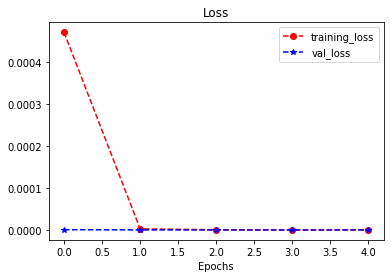

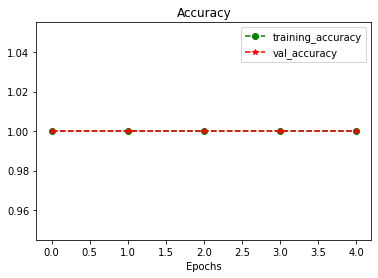

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_1)

## **Preparing fine tuning only certain number of layers**

In [ ]:
# Layers in loaded model
model.layers

In [ ]:
# Are these layers trainable?
for layer in model.layers:
  print(layers, layer.trainable)

In [ ]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

In [ ]:
# How many trainable varialbes are in our base model?
print(len(model_2.layers[2].trainable_variables))

In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10 layers
for layers in base_model.layers[:-10]:
  layers.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate by 10x*
               metrics=['accuracy'])

In [ ]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 expect with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history.epoch[-1] # start training from previous last epoch
                                               )

### **Creating a function to check the file size before and after converting it into tensorflow lite model**

In [ ]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [ ]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [ ]:
#Define a variable to store our model
MODEL_NAME = "eficientnetb0_black_pepper_finetune.h5"

In [ ]:
model.save(MODEL_NAME)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
convert_bytes(get_file_size(MODEL_NAME), "MB")

File size: 46.934 Megabytes


## **TF LITE MODEL**

In [ ]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model_finetune.tflite"

In [ ]:
# Convert the model
from tensorflow import lite
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = tf_lite_converter.convert()

In [ ]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model_efficientnet_finetune.tflite"

In [ ]:
# Save the model
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

4797728

## **Other ways to create tf lite models**

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
assets	keras_metadata.pb  saved_model.pb  variables


In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
!mkdir -p bin/tf_tutorial_2

In [ ]:
from pathlib import Path
PATH_DIR = Path.cwd()
dataset_dir = PATH_DIR.joinpath('bin/tf_tutorial_2')
saved_model_dir = dataset_dir.joinpath('/content/saved_model/my_model')
saved_h5_dir = dataset_dir.joinpath('/content/my_model.h5')

In [ ]:
# from keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# or from tf saved model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
# last from concrete functions
converter = tf.lite.TFLiteConverter.from_concrete_funcions(tf_path_concrete_functions)

In [ ]:
#saved_model_dir = "/content/saved_model/my_model"

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir.as_posix())

In [ ]:
# start conversion
tflite_model = converter.convert()

In [ ]:
# save model
tflite_model_file = dataset_dir.joinpath('model_fp32.tflite')
tflite_model_file.write_bytes(tflite_model)

16049284

## **3.0 Float16 quantization**

Size reduction: up to 50 %

Latency reduction: 2x

Accuracy: Insignificant loss accuracy

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir.as_posix())

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

In [ ]:
tflite_model = converter.convert()

In [ ]:
# save model
tflite_model_file = dataset_dir.joinpath('model_fp16.tflite')
tflite_model_file.write_bytes(tflite_model)

8107072

## **4.0 Dynamic int8 range quantization**
Size reduction: up to 75 %

Latency reduction: 2x/3x

Accuracy: Accuracy loss

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir.as_posix())

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [ ]:
tflite_model = converter.convert()

In [ ]:
# save model
tflite_model_file = dataset_dir.joinpath('model_int8_dynamic.tflite')
tflite_model_file.write_bytes(tflite_model)

4797728

## **5.0 Integer quantization with float fallback**
Size reduction: up to 75 %

Latency reduction: 3x/4x

Accuracy: Smallest loss accuracy

In [ ]:
num_calibration_steps = 1 # at least 100

def representative_dataset_gen():
      for i in range(num_calibration_steps):
        # Remember to pre-process your dataset as your training
        imgs = train_data[i:i+1]
        imgs = imgs / 255
        yield [imgs.astype('float32')]

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir.as_posix())

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen

In [ ]:
tflite_model = converter.convert()

In [ ]:
# save model
tflite_model_file = dataset_dir.joinpath('model_int8_fb.tflite')
tflite_model_file.write_bytes(tflite_model)